In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, auc,
                             confusion_matrix)
import seaborn as sns

In [2]:
import pandas as pd

df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/raw/train-00000-of-00001.parquet")

In [3]:
df = df.drop(columns=["id", "author", "subreddit", "link_id", "parent_id", "created_utc", "rater_id", "example_very_unclear"])

In [4]:
df.shape

(211225, 29)

In [5]:
df

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
emotion_columns = df.columns[1:]
df = df[df[emotion_columns].sum(axis = 1) <= 1]
ohe_columns = df.drop(columns=["text"]).columns


In [10]:
df.shape

(175231, 29)

In [11]:
df["noEmotion"] = (df[ohe_columns].sum(axis=1) == 0).astype(int)

In [12]:
df

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,noEmotion
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [14]:

tfidf_matrix = vectorizer.fit_transform(df['text'])

In [15]:
tfidf_matrix.shape

(175231, 30470)

In [16]:
def vectorize_get_X_y(dataframe):
    """
    Split the data into appropriate formats X, y
    preprocess text into vectorized format.
    """
    vec = TfidfVectorizer()
    tfidf_matrix = vec.fit_transform(dataframe["text"])
    # Get vector input X, and OHE label y
    return tfidf_matrix, dataframe.drop(columns = ["text"])

In [48]:
X, y = vectorize_get_X_y(df)

In [49]:
y

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,noEmotion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211221,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
ohe_columns = y.columns
ohe_columns

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'noEmotion'],
      dtype='object')

In [20]:
y[ohe_columns]

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,noEmotion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211221,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
y.iloc[1]

admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
noEmotion         1
Name: 1, dtype: int64

In [22]:
# Convert OHE to class labels
class_labels = np.argmax(y[ohe_columns].values, axis=1)

In [23]:
y["class_label"] = np.argmax(y[ohe_columns].values, axis = 1)
y = y.drop(columns=ohe_columns)

In [24]:
y

,class_label
0,25
1,28
2,27
3,18
4,27
...,...
211220,18
211221,5
211222,0
211223,2


In [25]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [26]:
X_train.shape

(140184, 30470)

In [27]:
X_test.shape

(35047, 30470)

In [28]:
X_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 393647 stored elements and shape (35047, 30470)>

In [29]:
y_train.shape

(140184, 1)

In [30]:
y_test.shape

(35047, 1)

In [31]:
y_test

,class_label
1952,3
171910,14
178628,27
204171,27
115330,27
...,...
86597,20
183619,4
117501,14
69952,24


In [32]:
## Test

In [33]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob")
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_train)

In [34]:
cm = confusion_matrix(y_train, y_pred)

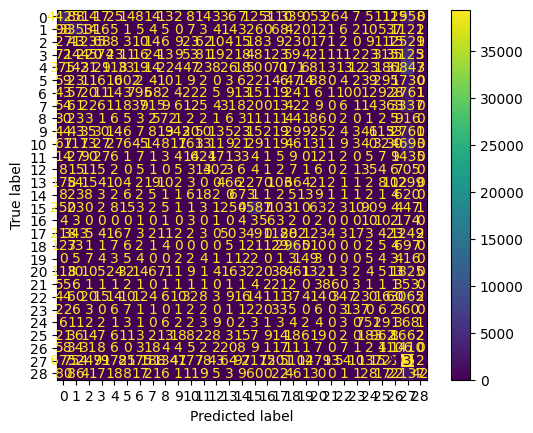

In [35]:
    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()


In [36]:
ohe_columns

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'noEmotion'],
      dtype='object')

In [143]:
ohe_columns

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'noEmotion'],
      dtype='object')

In [144]:
index=[f"True {cat}" for cat in ohe_columns]
columns=[f"Pred {cat}" for cat in ohe_columns]

In [145]:
index

['True admiration',
 'True amusement',
 'True anger',
 'True annoyance',
 'True approval',
 'True caring',
 'True confusion',
 'True curiosity',
 'True desire',
 'True disappointment',
 'True disapproval',
 'True disgust',
 'True embarrassment',
 'True excitement',
 'True fear',
 'True gratitude',
 'True grief',
 'True joy',
 'True love',
 'True nervousness',
 'True optimism',
 'True pride',
 'True realization',
 'True relief',
 'True remorse',
 'True sadness',
 'True surprise',
 'True neutral',
 'True noEmotion']

In [146]:
columns

['Pred admiration',
 'Pred amusement',
 'Pred anger',
 'Pred annoyance',
 'Pred approval',
 'Pred caring',
 'Pred confusion',
 'Pred curiosity',
 'Pred desire',
 'Pred disappointment',
 'Pred disapproval',
 'Pred disgust',
 'Pred embarrassment',
 'Pred excitement',
 'Pred fear',
 'Pred gratitude',
 'Pred grief',
 'Pred joy',
 'Pred love',
 'Pred nervousness',
 'Pred optimism',
 'Pred pride',
 'Pred realization',
 'Pred relief',
 'Pred remorse',
 'Pred sadness',
 'Pred surprise',
 'Pred neutral',
 'Pred noEmotion']

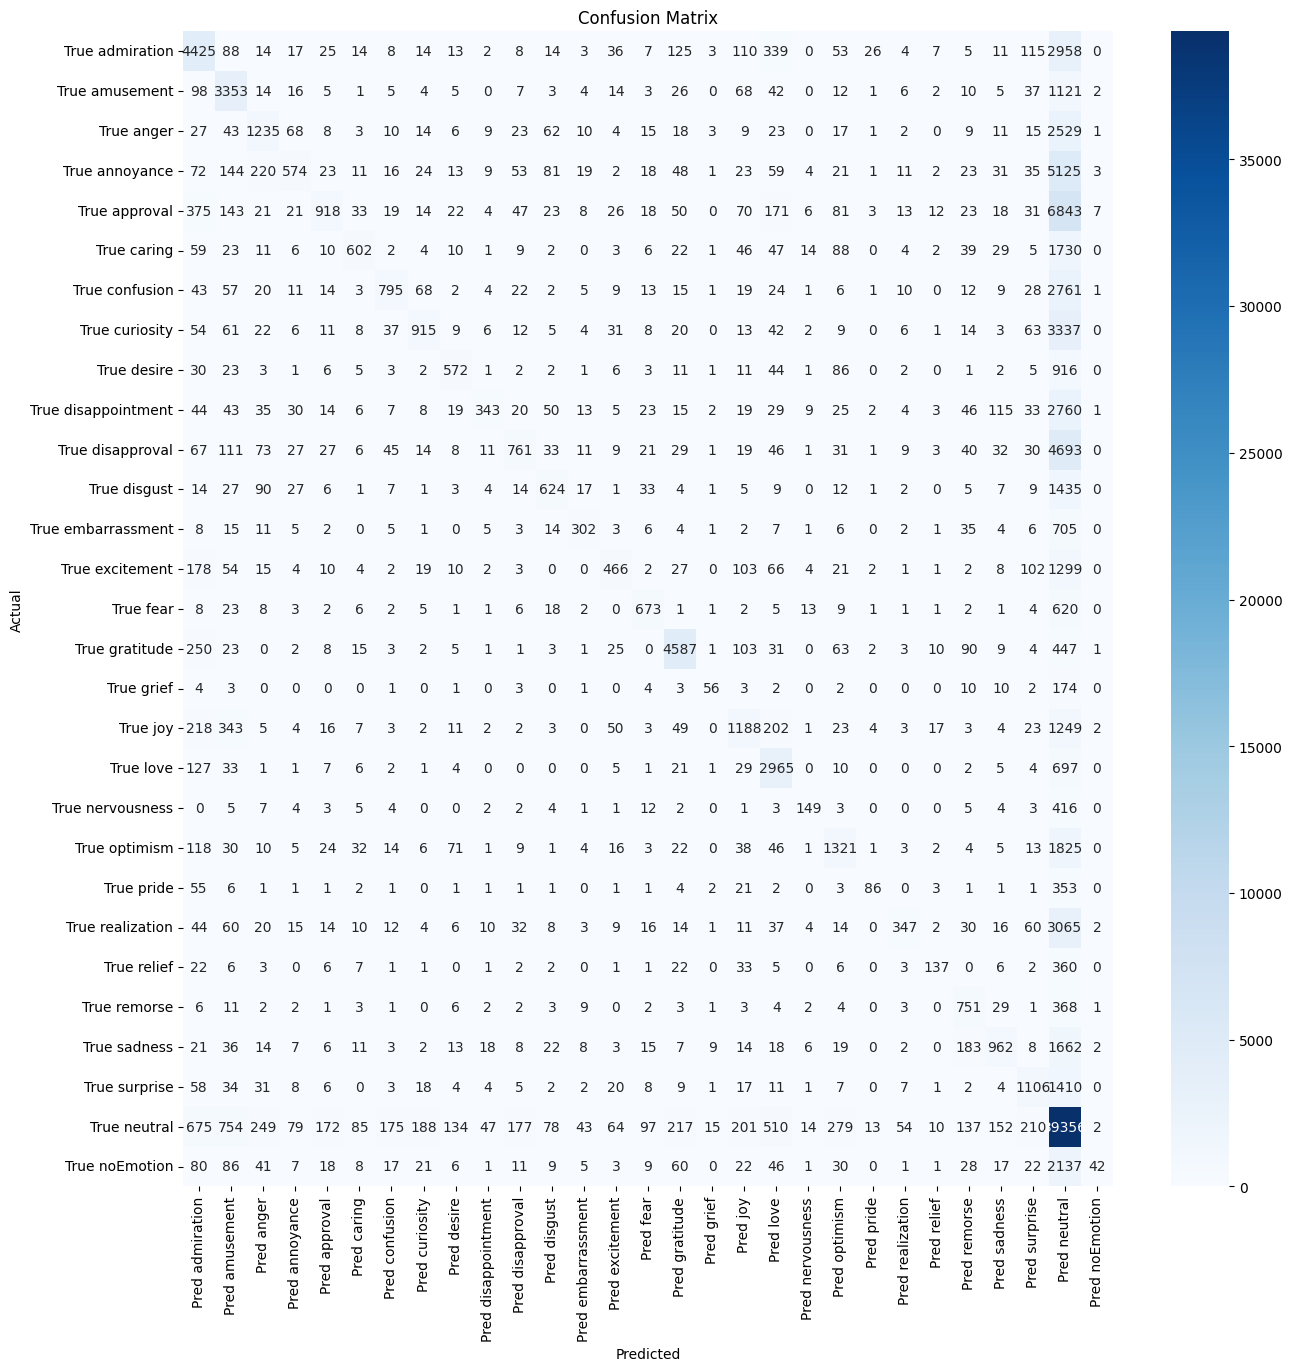

In [40]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Create a DataFrame for the confusion matrix for better readability
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f"True {cat}" for cat in ohe_columns], 
    columns=[f"Pred {cat}" for cat in ohe_columns]
)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [122]:
index=[f"True {cat}" for cat in categories]
columns=[f"Pred {cat}" for cat in categories]

In [57]:
from sklearn.metrics import classification_report
from tabulate import tabulate


In [59]:
    report = classification_report(y_train, y_pred, target_names = ohe_columns, output_dict = True)
    class_metrics = []
    for cat in ohe_columns:
        cat_name = f"{cat}"
        precision = report[str(cat)]["precision"]
        recall = report[str(cat)]["recall"]
        f1_score = report[str(cat)]["f1-score"]
        class_metrics.append([cat_name, precision, recall, f1_score])

    headers = ["class", "precision", "Recall", "F1-score"]
    table_class = tabulate(class_metrics, headers=headers, tablefmt= "grid", floatfmt = ".2f")
    print(table_class)


+----------------+-------------+----------+------------+
| class          |   precision |   Recall |   F1-score |
+================+=============+==========+============+
| admiration     |        0.62 |     0.52 |       0.57 |
+----------------+-------------+----------+------------+
| amusement      |        0.59 |     0.69 |       0.64 |
+----------------+-------------+----------+------------+
| anger          |        0.57 |     0.30 |       0.39 |
+----------------+-------------+----------+------------+
| annoyance      |        0.60 |     0.09 |       0.15 |
+----------------+-------------+----------+------------+
| approval       |        0.67 |     0.10 |       0.18 |
+----------------+-------------+----------+------------+
| caring         |        0.67 |     0.22 |       0.33 |
+----------------+-------------+----------+------------+
| confusion      |        0.66 |     0.20 |       0.31 |
+----------------+-------------+----------+------------+
| curiosity      |        0.68 